### Face Detection using MTCNN

In [1]:
pip install mtcnn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import mtcnn
mtcnn.__version__

'0.1.0'

In [3]:
from PIL import Image
import numpy as np
from mtcnn import MTCNN

def extract_face(image):
    # load image
    image = Image.open(image)
    image = image.convert('RGB')
    pixels = np.asarray(image)

    face_detector = MTCNN()
    faces = face_detector.detect_faces(pixels)

    # extract the first face
    x1, y1, width, height = faces[0]['box']
    x2, y2 = width+x1, height+y1
    face = pixels[y1:y2, x1:x2]

    # resize pixels to model size
    face = Image.fromarray(face).resize((160, 160))
    face = np.asarray(face)
    return face

2022-10-25 15:43:39.458760: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-10-25 15:43:39.897894: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


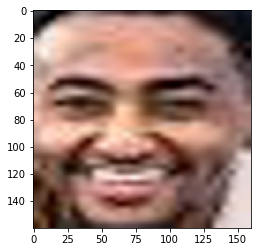

In [4]:
import matplotlib.pyplot as plt
test_image_1 = '../input/test-images/img1.jpg'
face = extract_face(test_image_1)
plt.imshow(face)

### Load Faces Data

In [5]:
import os

# load faces in a sub directory
def load_faces_from_directory(folder_path):
    i = 1
    faces = []
    for filename in os.listdir(folder_path):
        # get path
        path = folder_path + filename
        # get face
        face = extract_face(path)
        i += 1
        # add face to list
        faces.append(face)
    return faces

In [6]:
# load and extract faces in all sub directories present in main directory
def load_dataset(directory):
    X, y = list(), list()
    
    for subdir in os.listdir(directory):
        # get path
        path = directory + subdir + '/'
        # skip anything that isn't a directory
        if not os.path.isdir(path):
            continue
        # load all faces in the subdirectory
        faces = load_faces_from_directory(path)
        # add labels
        labels = [subdir for i in range(len(faces))]
        # summarize progress
        print(len(faces), "faces extracted for class:", subdir)
        # store data
        X.extend(faces)
        y.extend(labels)
    
    return np.asarray(X), np.asarray(y)

In [7]:
# training dataset
Xtrain, y_train = load_dataset('../input/faces-data/train/')
Xtest, y_test = load_dataset('../input/faces-data/val/')

print('Training Data:', Xtrain.shape, y_train.shape)
print('Test Data:', Xtest.shape, y_test.shape)

15 faces extracted for class: bill_gates
15 faces extracted for class: jeff_bezos
15 faces extracted for class: elon_musk
15 faces extracted for class: mark_zuckerberg
5 faces extracted for class: bill_gates
5 faces extracted for class: jeff_bezos
5 faces extracted for class: elon_musk
5 faces extracted for class: mark_zuckerberg
Training Data: (60, 160, 160, 3) (60,)
Test Data: (20, 160, 160, 3) (20,)


### Load pre-trained facenet model

In [8]:
from keras.models import load_model

model = load_model('../input/facenet-keras/facenet_keras.h5')

# input and output shapes
print(model.inputs)
print(model.outputs)

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


### Create Face Embeddings

In [9]:
def get_embedding(pixels):
    # scale pixel values
    pixels = pixels.astype('float32')
    # standardize pixel values
    mean, std = pixels.mean(), pixels.std()
    pixels = (pixels - mean)/std
    # transform pixels into one sample
    samples = np.expand_dims(pixels, axis=0)
    # make prediction to get embedding
    y_pred = model.predict(samples)
    return y_pred[0]

In [10]:
# convert faces to embeddings
def convert_to_embedding(X):
    new_X = []
    
    for pixels in X:
        embedding = get_embedding(pixels)
        new_X.append(embedding)
    
    return np.asarray(new_X)

In [11]:
X_train = convert_to_embedding(Xtrain)
X_test = convert_to_embedding(Xtest)
print(X_train.shape)
print(X_test.shape)

(60, 128)
(20, 128)


### Face Classification

#### Data Preprocessing

In [12]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# normalize input variables
normalizer = Normalizer(norm='l2')
X_train = normalizer.transform(X_train)
X_test = normalizer.transform(X_test)

# label encode target variable
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [13]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

svc = SVC(kernel='linear')
forest = RandomForestClassifier()

In [14]:
from sklearn.metrics import accuracy_score

for model in (svc, forest):
    # train model
    model.fit(X_train, y_train)
    # make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    # get accuracy
    acc_train = accuracy_score(y_pred_train, y_train)
    acc_test = accuracy_score(y_pred_test, y_test)
    # display results
    print(model)
    print('=========================')
    print('Training Accuracy: %.2f%%'%(acc_train*100))
    print('Test Accuracy: %.2f%%'%(acc_test*100))
    print()

SVC(kernel='linear')
Training Accuracy: 100.00%
Test Accuracy: 100.00%

RandomForestClassifier()
Training Accuracy: 100.00%
Test Accuracy: 100.00%



#### Display Results

In [15]:
import random

# test model on a random example from the test dataset
random_face = random.choice([i for i in range(X_test.shape[0])])
pixels = Xtest[random_face]
embedding = X_test[random_face]
face_class = y_test[random_face]
name = le.inverse_transform([face_class])

In [16]:
# prediction for the face
samples = np.expand_dims(embedding, axis=0)
predicted_class = model.predict(samples)
probability = model.predict_proba(samples)

In [17]:
# get name
class_index = predicted_class[0]
class_probability = probability[0,class_index] * 100
predict_names = le.inverse_transform(predicted_class)
print('Predicted: %s (%.2f%%)' % (predict_names[0], class_probability))
print('Expected: %s' % name[0])

Predicted: jeff_bezos (94.00%)
Expected: jeff_bezos


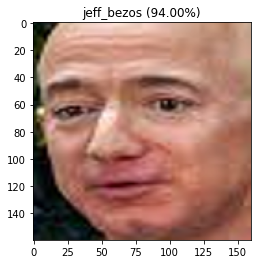

In [18]:
# plot face
plt.imshow(pixels)
title = '%s (%.2f%%)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()